<a href="https://colab.research.google.com/github/GerGoar/Image_Deep_Learning_Project/blob/main/Classifier_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

In [2]:
## Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import libraries
!pip install datasets
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import random
from collections import Counter, defaultdict
from torchvision.datasets import ImageFolder
import pandas as pd
import seaborn as sns

In [4]:
# Loading the Dataset
# REMOVE any old copy
!rm -rf /content/FaceDataset

# Extract zip file from Google Drive
zip_path = "/content/drive/MyDrive/Deep Learning Applications/Full_DataSet.zip"
extract_path = "/content/FaceDataset"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [6]:
# Set random seeds for reproducibility
random.seed(8)
np.random.seed(8)
torch.manual_seed(8)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(8)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
# Check the structure
print("Dataset structure:")
for root, dirs, files in os.walk(extract_path):
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files)-5} more files")

# Find the actual dataset directory (adjust if needed)
dataset_dir = extract_path
if "Full DataSet" in os.listdir(extract_path):
    dataset_dir = os.path.join(extract_path, "Full DataSet")

print(f"\nUsing dataset directory: {dataset_dir}")

# Load dataset using HuggingFace datasets
dataset = load_dataset(
    "imagefolder",
    data_dir=dataset_dir,
)

print(dataset)
print(f"Number of classes: {len(dataset['train'].features['label'].names)}")
print(f"Class names: {dataset['train'].features['label'].names}")


Dataset structure:
FaceDataset/
  Full DataSet/
    Gerardo/
      IMG_3836_frame_831.jpg
      IMG_3834_frame_145.jpg
      IMG_3826_frame_1088.jpg
      IMG_3834_frame_995.jpg
      IMG_3836_frame_737.jpg
      ... and 5478 more files
    Oliver/
      IMG_3827_frame_523.jpg
      IMG_3835_frame_1636.jpg
      IMG_3835_frame_355.jpg
      IMG_3835_frame_1778.jpg
      IMG_3827_frame_139.jpg
      ... and 5441 more files
    Timothy/
      IMG_3839_frame_1651.jpg
      IMG_3840_frame_1595.jpg
      IMG_3839_frame_1242.jpg
      IMG_3840_frame_982.jpg
      IMG_3839_frame_6.jpg
      ... and 5542 more files
  __MACOSX/
    ._Full DataSet
    Full DataSet/
      ._Oliver
      ._Timothy
      ._Gerardo
      Gerardo/
        ._IMG_3836_frame_795.jpg
        ._IMG_3836_frame_1797.jpg
        ._IMG_3826_frame_27.jpg
        ._IMG_3834_frame_1462.jpg
        ._IMG_3834_frame_1289.jpg
        ... and 5478 more files
      Oliver/
        ._IMG_3827_frame_51.jpg
        ._IMG_3835_frame_1346

Resolving data files:   0%|          | 0/16476 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 16476
    })
})
Number of classes: 3
Class names: ['Gerardo', 'Oliver', 'Timothy']


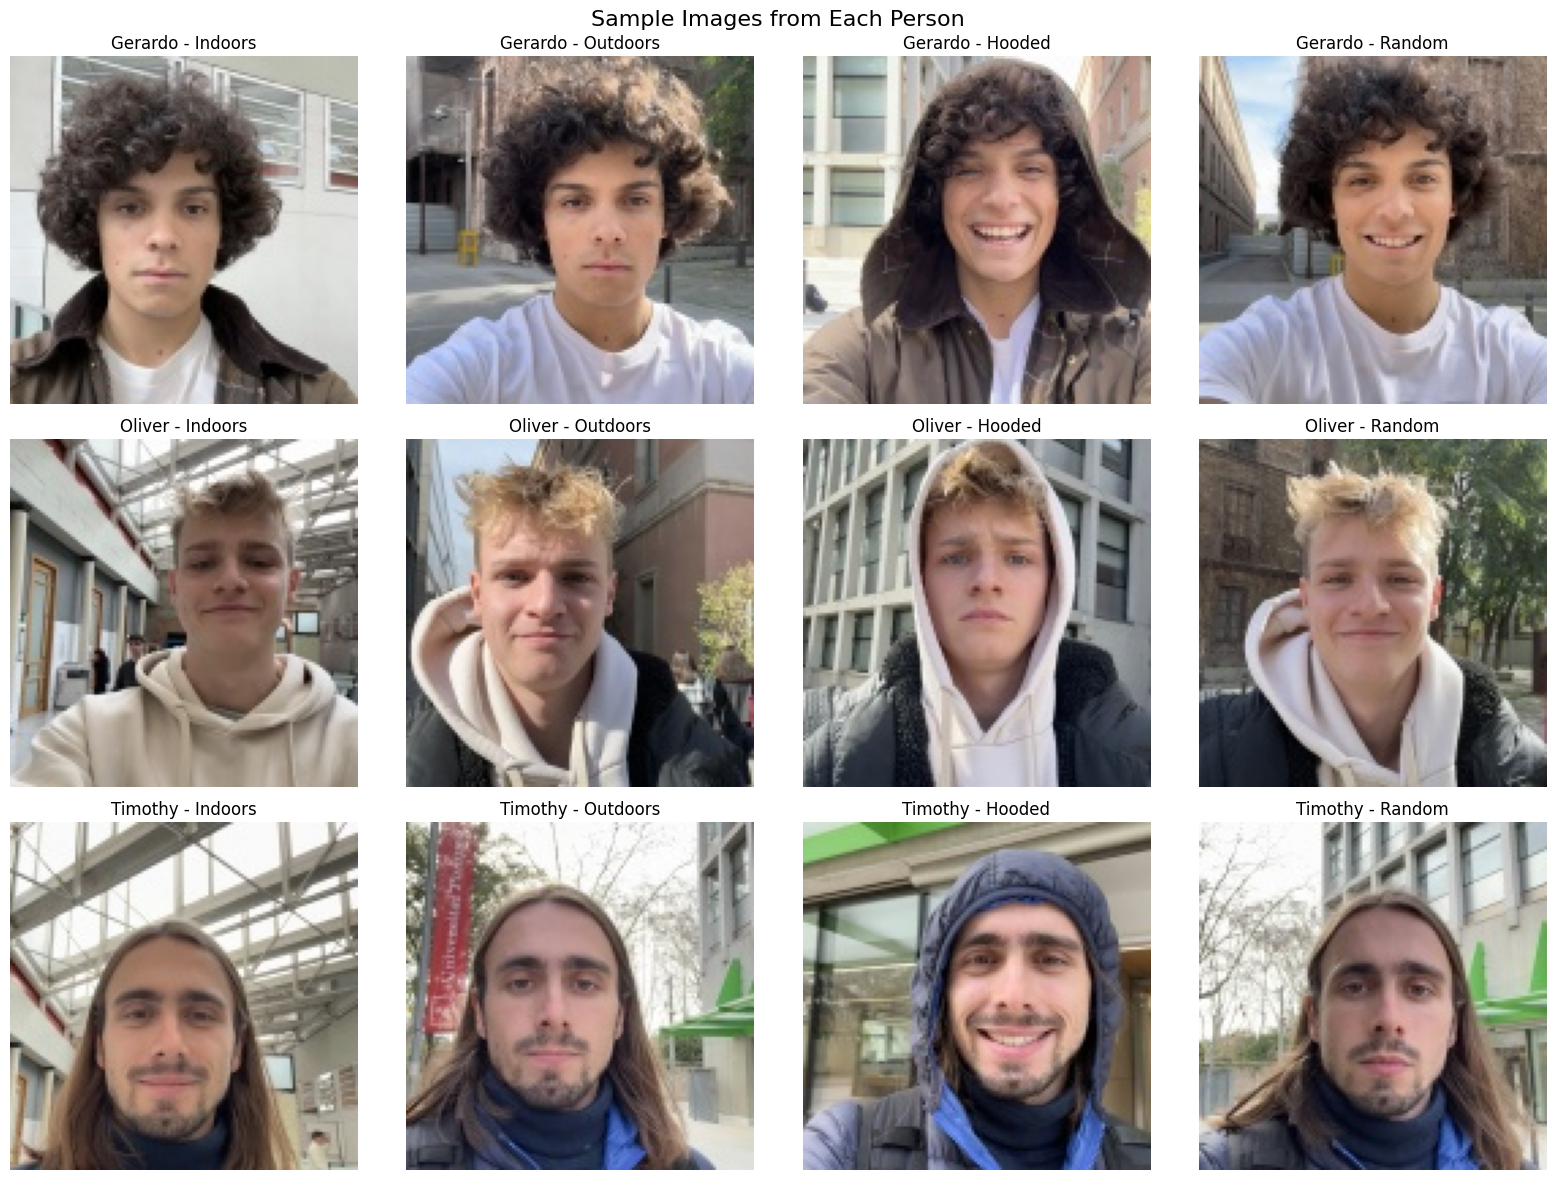


Dataset Statistics:
Gerardo: 5483 images
Oliver: 5446 images
Timothy: 5547 images


In [8]:
# Visualize some examples from each person
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Sample Images from Each Person', fontsize=16)

for person_idx in range(3):  # Gerardo, Oliver, Timo
    # Find images for this person
    person_images = [item for item in dataset["train"] if item["label"] == person_idx]
    person_name = dataset['train'].features['label'].names[person_idx]

    if len(person_images) > 0:
        # Calculate indices for beginning, middle, and end
        total_images = len(person_images)
        beginning_idx = 0
        middle_idx = total_images // 2
        end_idx = total_images - 1

        # Select a random index for the 4th image
        import random
        random_idx = random.randint(0, total_images - 1)

        # Define which images to show with labels
        sample_indices = [beginning_idx, middle_idx, end_idx, random_idx]
        sample_labels = ["Indoors", "Outdoors", "Hooded", "Random"]

        for i in range(4):
            if i < len(sample_indices):
                img_idx = sample_indices[i]
                axs[person_idx, i].imshow(person_images[img_idx]["image"])
                axs[person_idx, i].set_title(f"{person_name} - {sample_labels[i]}")
            axs[person_idx, i].set_axis_off()

plt.tight_layout()
plt.show()

# Print dataset statistics
print("\nDataset Statistics:")
for idx, name in enumerate(dataset['train'].features['label'].names):
    count = sum(1 for item in dataset["train"] if item["label"] == idx)
    print(f"{name}: {count} images")

In [9]:
# Define transformations with data augmentation for training
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),                                              # Standard input size for ResNet
    transforms.RandomHorizontalFlip(p=0.5),                                   # Random horizontal flip
    transforms.RandomRotation(degrees=10),                                      # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color augmentation
    transforms.ToTensor(),                                                      # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create train-validation split
train_val_dataset = dataset["train"]
train_indices, val_indices = train_test_split(
    range(len(train_val_dataset)),
    test_size=0.2,
    stratify=[item['label'] for item in train_val_dataset],
    random_state=42
)

print(f"\nDataset split:")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")

# Create PyTorch Dataset class for faces
class FaceDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices=None, transform=None):
        self.dataset = dataset
        self.indices = indices if indices is not None else range(len(dataset))
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.dataset[self.indices[idx]]
        image = sample['image']
        label = sample['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets and dataloaders
train_dataset = FaceDataset(train_val_dataset, train_indices, transform_train)
val_dataset = FaceDataset(train_val_dataset, val_indices, transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print class distribution in train and validation sets
train_labels = [train_val_dataset[i]['label'] for i in train_indices]
val_labels = [train_val_dataset[i]['label'] for i in val_indices]

print("\nClass distribution in training set:")
for idx, name in enumerate(dataset['train'].features['label'].names):
    count = train_labels.count(idx)
    print(f"{name}: {count} images")

print("\nClass distribution in validation set:")
for idx, name in enumerate(dataset['train'].features['label'].names):
    count = val_labels.count(idx)
    print(f"{name}: {count} images")


Dataset split:
Training samples: 13180
Validation samples: 3296

Class distribution in training set:
Gerardo: 4386 images
Oliver: 4357 images
Timothy: 4437 images

Class distribution in validation set:
Gerardo: 1097 images
Oliver: 1089 images
Timothy: 1110 images


# ResNet Classifier

In [10]:
# Define the Face Classifier Model
class FaceClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(FaceClassifier, self).__init__()
        # Load pre-trained ResNet-18
        self.backbone = models.resnet18(pretrained=True)

        # Freeze early layers for transfer learning
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Replace the final layer for our 3-class problem
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)

        # Unfreeze the final layer
        for param in self.backbone.fc.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.backbone(x)


In [10]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = FaceClassifier(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, f1


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


In [11]:
# Training loop
num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_face_classifier.pth')
        print(f'🎉 New best model saved! Val Acc: {val_acc:.2f}%')

    scheduler.step()

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting training...

Epoch 1/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.1129 | Train Acc: 98.09%
Val Loss: 0.0169 | Val Acc: 100.00% | Val F1: 1.0000
🎉 New best model saved! Val Acc: 100.00%

Epoch 2/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>  
 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()^
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^if w.is_alive():^
^  ^^  ^ ^ ^ ^^^^^^^^^^^^^^

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0142 | Train Acc: 99.93%
Val Loss: 0.0092 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 3/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0069 | Train Acc: 100.00%
Val Loss: 0.0033 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 4/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^
 ^  ^ ^ ^  ^^^^^^^^^^^^^^^
^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    
assert self._parent_pid == os.getpid(), 'can only test a child process'
   File "/usr/lib/pytho

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0062 | Train Acc: 99.95%
Val Loss: 0.0030 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 5/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0034 | Train Acc: 99.99%
Val Loss: 0.0015 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 6/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0036 | Train Acc: 99.94%
Val Loss: 0.0010 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 7/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0022 | Train Acc: 99.99%
Val Loss: 0.0006 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 8/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Exception ignored in: Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()if w.is_alive():

   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
       if w.is_alive():   
^  ^^^^^    ^ ^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^^^assert self._parent_pid == os.getpid(), 'can only test a child process'^
  File "/usr/lib/python3

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0019 | Train Acc: 99.99%
Val Loss: 0.0009 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 9/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^
    self._shutdown_workers()  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
 if w.is_alive():  
              ^ ^^^^^^^^^^^^^^^^^^^^^
^ 

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0017 | Train Acc: 99.98%
Val Loss: 0.0006 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 10/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>  
   Traceback (most recent call last):
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
  ^ ^^ 
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^  ^ ^ ^   ^^ ^ ^^^^^^^^
  File 

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0017 | Train Acc: 99.99%
Val Loss: 0.0009 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 11/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0021 | Train Acc: 99.98%
Val Loss: 0.0006 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 12/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0016 | Train Acc: 100.00%
Val Loss: 0.0008 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 13/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0021 | Train Acc: 99.98%
Val Loss: 0.0005 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 14/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0019 | Train Acc: 99.98%
Val Loss: 0.0008 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 15/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0022 | Train Acc: 99.95%
Val Loss: 0.0007 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 16/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bf8b46e6e80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0015 | Train Acc: 99.99%
Val Loss: 0.0008 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 17/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0017 | Train Acc: 99.98%
Val Loss: 0.0007 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 18/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0017 | Train Acc: 99.98%
Val Loss: 0.0007 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 19/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0014 | Train Acc: 100.00%
Val Loss: 0.0006 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 20/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0014 | Train Acc: 99.99%
Val Loss: 0.0005 | Val Acc: 100.00% | Val F1: 1.0000

Training completed! Best validation accuracy: 100.00%


In [1]:
# Plot training history
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot losses
ax1.plot(train_losses, label='Training Loss', color='blue', marker='o')
ax1.plot(val_losses, label='Validation Loss', color='red', marker='s')
ax1.set_title('Model Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot accuracies
ax2.plot(train_accs, label='Training Accuracy', color='blue', marker='o')
ax2.plot(val_accs, label='Validation Accuracy', color='red', marker='s')
ax2.set_title('Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Plot F1 scores
ax3.plot(val_f1s, label='Validation F1 Score', color='green', marker='^')
ax3.set_title('F1 Score')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1 Score')
ax3.legend()
ax3.grid(True)

# Plot learning rate
lrs = [scheduler.get_last_lr()[0] for _ in range(num_epochs)]
ax4.plot(lrs, label='Learning Rate', color='orange', marker='d')
ax4.set_title('Learning Rate Schedule')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Learning Rate')
ax4.legend()
ax4.grid(True)
ax4.set_yscale('log')

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# Simple Classifier

In [11]:
# Define a Simple CNN Classifier from scratch
class SimpleFaceClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleFaceClassifier, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)  # 224x224 -> 112x112

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)  # 112x112 -> 56x56

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)  # 56x56 -> 28x28

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Global Average Pooling instead of flatten to reduce parameters
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 14x14 -> 1x1

        # Classifier
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # First block
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))

        # Second block
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))

        # Third block
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))

        # Fourth block
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))

        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc(x)

        return x

# Alternative: Even simpler CNN for comparison
class TinyFaceClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(TinyFaceClassifier, self).__init__()

        # Just 2 convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(4, 4)  # 224x224 -> 56x56

        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(4, 4)  # 56x56 -> 14x14

        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 14x14 -> 1x1

        # Simple classifier
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [12]:
# Initialize model, loss, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Choose which model to use:
# Option 1: Simple CNN (4 conv layers)
model = SimpleFaceClassifier(num_classes=3).to(device)

# Option 2: Tiny CNN (2 conv layers) - uncomment to use instead
# model = TinyFaceClassifier(num_classes=3).to(device)

Using device: cuda


In [13]:
# Print model architecture and parameter count
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {model.__class__.__name__}")
print(f"Total trainable parameters: {count_parameters(model):,}")
print("\nModel architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # More aggressive decay

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return epoch_loss, epoch_acc, f1

# Training loop
num_epochs = 20
train_losses, train_accs = [], []
val_losses, val_accs, val_f1s = [], [], []
best_val_acc = 0.0

print("Starting training...")
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation phase
    val_loss, val_acc, val_f1 = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_face_classifier.pth')
        print(f'🎉 New best model saved! Val Acc: {val_acc:.2f}%')

    scheduler.step()

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Model: SimpleFaceClassifier
Total trainable parameters: 390,147

Model architecture:
SimpleFaceClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>if w.is_alive():

 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers() 
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^^if w.is_alive():^^^^
^ ^  ^^^ 
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'
    ^ ^^ ^^^      ^^^^^^^^^^^^^^^^^^^

Train Loss: 0.1372 | Train Acc: 95.91%
Val Loss: 0.0152 | Val Acc: 99.82% | Val F1: 0.9982
🎉 New best model saved! Val Acc: 99.82%

Epoch 2/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0281 | Train Acc: 99.34%
Val Loss: 0.0160 | Val Acc: 99.85% | Val F1: 0.9985
🎉 New best model saved! Val Acc: 99.85%

Epoch 3/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0153 | Train Acc: 99.66%
Val Loss: 0.0005 | Val Acc: 100.00% | Val F1: 1.0000
🎉 New best model saved! Val Acc: 100.00%

Epoch 4/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0121 | Train Acc: 99.76%
Val Loss: 0.0046 | Val Acc: 99.94% | Val F1: 0.9994

Epoch 5/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0106 | Train Acc: 99.68%
Val Loss: 0.0002 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 6/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

    self._shutdown_workers()
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
        ^^ ^^ ^ ^^ ^ ^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
^^     ^^^^
  File "/usr/lib/p

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0056 | Train Acc: 99.85%
Val Loss: 0.0009 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 7/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>self._shutdown_workers()

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
          if w.is_alive():
     ^^^ ^ ^ ^^^^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^

  File "/usr/lib/python

Train Loss: 0.0026 | Train Acc: 99.95%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 8/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0019 | Train Acc: 99.98%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 9/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0045 | Train Acc: 99.86%
Val Loss: 0.0002 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 10/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0027 | Train Acc: 99.94%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 11/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0010 | Train Acc: 99.99%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 12/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0009 | Train Acc: 99.98%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 13/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>^
Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    ^
if w.is_alive():A

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
 Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       ^^self._shutdown_workers()
^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    if w.is_alive():^
^^ ^^ ^
   File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'  ^
 ^ ^ ^ ^  ^ ^ ^ ^ ^ ^^^^
^  File "/

Train Loss: 0.0024 | Train Acc: 99.95%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 14/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0007 | Train Acc: 99.99%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 15/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0042 | Train Acc: 99.89%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 16/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0013 | Train Acc: 99.97%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 17/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0006 | Train Acc: 99.98%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 18/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

     
if w.is_alive():     assert self._parent_pid == os.getpid(), 'can only test a child process'          ^ ^ ^ ^ ^ ^ ^^^^^^^^^^^^^
  Fil

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0005 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 19/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0> 
Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
 ^^^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^^    if w.is_alive():^
^^ ^ ^^ ^^ ^ ^^ ^ ^^^

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d9e999162a0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^^^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
if w.is_alive(): 
               ^ ^ ^^^^^^^^^^^^^^^^^^^^
^ 

Train Loss: 0.0005 | Train Acc: 99.99%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Epoch 20/20
--------------------------------------------------


Training:   0%|          | 0/412 [00:00<?, ?it/s]

Validation:   0%|          | 0/103 [00:00<?, ?it/s]

Train Loss: 0.0004 | Train Acc: 100.00%
Val Loss: 0.0000 | Val Acc: 100.00% | Val F1: 1.0000

Training completed! Best validation accuracy: 100.00%
